In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.io import loadmat 
import pickle 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
# load choice matrices 
cmats = loadmat('datasets/human_choices.mat')

Text(0.5, 1.0, 'Interleaved - Task B')

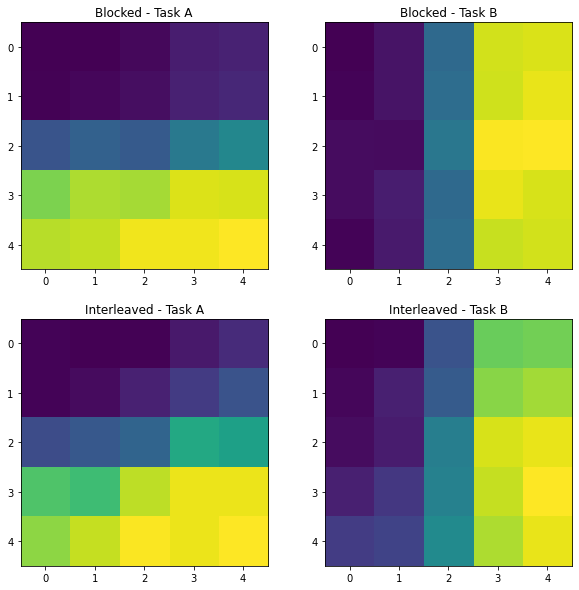

In [3]:
cmats.keys()
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(cmats['cmat_b_north'].mean(0))
plt.title('Blocked - Task A')

plt.subplot(2,2,2)
plt.imshow(cmats['cmat_b_south'].mean(0))
plt.title('Blocked - Task B')

plt.subplot(2,2,3)
plt.imshow(cmats['cmat_i_north'].mean(0))
plt.title('Interleaved - Task A')

plt.subplot(2,2,4)
plt.imshow(cmats['cmat_i_south'].mean(0))
plt.title('Interleaved - Task B')


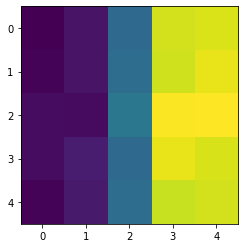

In [16]:
plt.imshow(y.reshape(5,5))